# SIADS 593 Milestone I -  Comprehensive Oral Exam - Greg Holden

# Scenario Overview: 

A multinational corporation ("The Company") is considering building a new manufacturing facility.   

The CEO read an article citing growth opportunities in three emerging markets -- Southeast Asia, Eastern Europe and Africa.  

The Company's market research team has narrowed the focus down to a target list of 18 countries -- 6 in each of the 3 regions.

The Company's product is only modestly complex.

The CEO is generally very focused on "growth" - sales growth, profit growth, and especially share price growth  - and has instructed the team to focus on "high-growth" markets.

The Data Science team has been asked to (a) analyze the suitability of these three regions, and (b) recommend one country for the new facility.  

The Data Science team has been given access to the World Bank's WDI database to conduct this analysis.

# The first step is to load the necessary modules:

In [147]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
import altair as alt
import plotly as plotly
import plotly.express as px

In [148]:
alt.renderers.enable('default')

RendererRegistry.enable('default')

In [149]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

# The next step is to import the excel file containing all of the WDI data, create a Pandas DataFrame, and review the first few entries.

In [150]:
# Load WDI data
df_WDI = pd.read_excel('WDIEXCEL.xlsx')
df_WDI.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,16.433999,16.789043,17.196986,17.597176,18.034249,18.345878,18.695306,19.149942,19.501837,NaN
1,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,6.196543,6.397917,6.580066,6.786218,6.941323,7.096843,7.254828,7.460783,7.599289,NaN
2,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,37.434876,37.660864,37.857526,38.204173,38.303515,38.421813,38.482409,38.692053,38.793983,NaN


# Let's review the completeness of the data and the datatypes.

In [151]:
#df_WDI.info()

# It is also helpful to get a sense as to what % of values are missing by year.

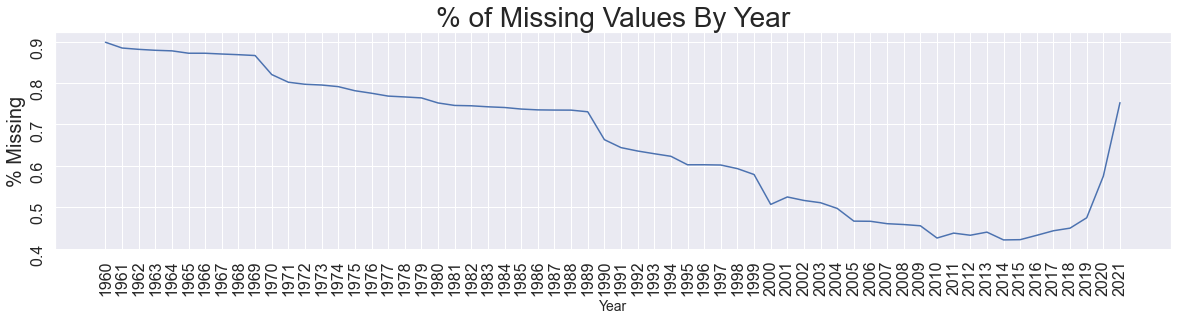

In [152]:
# Calculate the % of missing items in each column (mainly the years).  
# This is a proxy for temporal completeness.

# Get total number of missing values by year then show as %.
missing_WDI = df_WDI.isna().sum() / len(df_WDI)

# Review the data
#missing_WDI.tail(50)

# Create line plot
fig = plt.gcf()
fig.set_size_inches(20, 4)

# Format line plot
plt.title("% of Missing Values By Year",fontsize=28)
plt.xlabel('Year',fontsize=14)
plt.ylabel('% Missing',fontsize=20)
plt.tick_params(labelsize=16,rotation=90)

# Plot only columns with Years
plt.plot(missing_WDI[4:66])

# Show plot
plt.show()

# We can also look at how many unique Indicator Codes and Country Names there are in the data.

In [153]:
# Calculate number of unique Indicator Codes
uni_codes = df_WDI['Indicator Code'].unique()
print("Number of unique Indicator Codes: ",len(uni_codes))

# Calculate number of unique country names
uni_countries = df_WDI['Country Name'].unique()
print("Number of unique Country Names: ",len(uni_countries))

Number of unique Indicator Codes:  1442
Number of unique Country Names:  266


There are a lot of missing values in this dataset - particularly the further back we go in time.  But also interesting that 2020 and 2021 have less complete data.

Also worth noting that this dataset is still very large and covers all indicators and all countries.

We will narrow the dataset down shortly.

# Before we narrow down the dataset, it will be easier to analyze if we change the format of the data frame from wide to long.  

# Let's use pd.melt to do this.

In [154]:
# Use pd.melt to change dataframe from wide to long
df_WDI_melted = pd.melt(df_WDI,id_vars=['Country Name','Country Code','Indicator Name','Indicator Code'],
                       var_name='Year',value_name='Value')
df_WDI_melted.head()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Value
0,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,1960,NaN
1,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,1960,NaN
2,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,1960,NaN
3,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,1960,NaN
4,Africa Eastern and Southern,AFE,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,1960,NaN


Let's once again check the data types.

In [155]:
df_WDI_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23781464 entries, 0 to 23781463
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Country Name    object 
 1   Country Code    object 
 2   Indicator Name  object 
 3   Indicator Code  object 
 4   Year            object 
 5   Value           float64
dtypes: float64(1), object(5)
memory usage: 1.1+ GB


One noteworthy item here is that the "Year" column is an object.  That will need to be addressed shortly.

# The next major step is to narrow our focus by choosing two thematic subsets.  

# The first of these will be from the "Economy" section of indicators.  

# We will take a selection of relevant variables based on indicator codes.

In [156]:
# Create lists of selected indicator codes related to 'Economy' theme

growth_codes = ['NY.GDP.MKTP.CD','NY.GDP.MKTP.KD.ZG','NV.AGR.TOTL.KD.ZG','NV.IND.TOTL.KD.ZG',
                'NV.IND.MANF.KD.ZG','NV.SRV.TOTL.KD.ZG','NE.CON.TOTL.KD.ZG','NE.GDI.TOTL.KD.ZG',
                'NE.EXP.GNFS.KD.ZG','NE.IMP.GNFS.KD.ZG','NV.AGR.TOTL.ZS','NV.IND.TOTL.ZS',
                'NV.SRV.TOTL.ZS','NE.CON.TOTL.ZS','NE.GDI.TOTL.ZS','NE.EXP.GNFS.ZS','NE.IMP.GNFS.ZS']

income_savings_codes = ['NY.GNP.PCAP.CD','NY.GNP.PCAP.PP.CD','SP.POP.TOTL',
                        'NY.GNS.ICTR.ZS','NY.ADJ.SVNG.GN.ZS']

balance_payments_codes = ['TX.VAL.MRCH.XD.WD','TM.VAL.MRCH.XD.WD','BX.TRF.PWKR.DT.GD.ZS',
                          'BN.CAB.XOKA.GD.ZS','BX.KLT.DINV.WD.GD.ZS']

prices_trades_codes = ['FP.CPI.TOTL','TX.UVI.MRCH.XD.WD','TM.UVI.MRCH.XD.WD','TT.PRI.MRCH.XD.WD']

labor_prod_codes = ['SL.GDP.PCAP.EM.KD','SL.UEM.TOTL.ZS','NV.AGR.EMPL.KD','NV.IND.EMPL.KD',
                    'NV.SRV.EMPL.KD']

# Combined selected Economy codes into one list
total_economy_codes = growth_codes + income_savings_codes + balance_payments_codes + prices_trades_codes + labor_prod_codes

# Calculate how many Economy codes are in the list
print(len(total_economy_codes))

36


# The second major theme we will analyze is "People". 

Similarly, we can create a subset of relevant indicator codes.

In [157]:
# Create lists of codes related to 'People' theme

population_codes = ['SP.POP.TOTL','SP.POP.GROW','SP.DYN.CBRT.IN','SP.DYN.CDRT.IN','SP.DYN.TFRT.IN',
                    'SP.DYN.LE00.MA.IN','SP.DYN.LE00.FE.IN','SP.POP.DPND.YG','SP.POP.DPND.OL']


education_codes = ['SE.XPD.TOTL.GD.ZS','SE.PRM.ENRR','SE.SEC.ENRR','SE.TER.ENRR',
                   'SE.SEC.PROG.ZS','SE.PRM.CMPT.ZS','SE.ADT.1524.LT.ZS']

labor_codes = ['SL.TLF.CACT.ZS','SL.AGR.EMPL.ZS','SL.IND.EMPL.ZS','SL.SRV.EMPL.ZS',
               'SL.EMP.TOTL.SP.ZS','SL.UEM.TOTL.ZS','SL.TLF.0714.ZS']

health_codes = ['SH.STA.STNT.ZS','SH.STA.MMRT','SH.DYN.MORT','SH.HIV.INCD.ZS',
                'SH.DYN.NCOM.ZS','SH.STA.TRAF.P5','SP.ADO.TFRT','SH.UHC.OOPC.10.ZS']

gender_codes = ['SE.ENR.PRSC.FM.ZS','SP.M18.2024.FE.ZS','SH.FPL.SATM.ZS','SL.TLF.CACT.FM.ZS',
                'SL.EMP.SMGT.FE.ZS','SG.VAW.1549.ZS','SG.GEN.PARL.ZS']

# Combine all People codes into one list
total_people_codes = population_codes + education_codes + labor_codes + health_codes + gender_codes

# Calculate how many People codes are in the list
print(len(total_people_codes))

38


# We can also search the list of available codes based on keywords.

In [158]:
# Load list of Indicator Names and Codes
#indic_names_codes = pd.read_csv('WDISeries.csv')
#print(indic_names_codes.head())

# Choose keyword(s)
#keyword = 'Female'

# Search for matching Indicator Names 
#new_indic = indic_names_codes[indic_names_codes['Indicator Name'].str.contains(keyword,case=False)]
#print("Number of relevant matches: ", len(new_indic))
#new_indic.head(3)

#other_codes = []

We can then combine the Economy, People and Other indicator codes into one large list.

In [159]:
# Combine Economy and People codes into single list
economy_people_codes = total_economy_codes + total_people_codes

# Calculate length of combined list
print(len(economy_people_codes))

74


# Now we can create a subset of the WDI dataset based only on the chosen Economy and People indicators

In [160]:
# Create subset of df_WDI_melted based on selected Economy and People codes
df_economy_people = df_WDI_melted.loc[df_WDI_melted['Indicator Code'].isin(economy_people_codes)]

# Review first 5 entries
df_economy_people.head()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Value
30,Africa Eastern and Southern,AFE,"Adjusted net savings, including particulate em...",NY.ADJ.SVNG.GN.ZS,1960,NaN
50,Africa Eastern and Southern,AFE,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,141.457567
57,Africa Eastern and Southern,AFE,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,5.626944
58,Africa Eastern and Southern,AFE,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,83.668705
70,Africa Eastern and Southern,AFE,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.ZS,1960,NaN


# Next, after conducting some preliminary research we can further narrow this dataset down to only the 3 regions and 18 countries we want to consider for the new facility.

In [161]:
# Create list of select countries to analyze
select_countries = ['Vietnam','Cambodia','Thailand','Bangladesh','Malaysia','Philippines',
                    'Romania','Poland','Hungary','Bulgaria','Serbia','Croatia',
                    'Kenya','Morocco','Rwanda','Nigeria','South Africa','Egypt, Arab Rep.']

In [162]:
# Create subset of df_economy_people based on select_countries list
df_select_countries = df_economy_people[df_economy_people['Country Name'].isin(select_countries)]
df_select_countries.tail()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Value
23774054,Vietnam,VNM,"Services, value added (% of GDP)",NV.SRV.TOTL.ZS,2021,41.207868
23774055,Vietnam,VNM,"Services, value added (annual % growth)",NV.SRV.TOTL.KD.ZG,2021,1.568274
23774060,Vietnam,VNM,"Services, value added per worker (constant 201...",NV.SRV.EMPL.KD,2021,NaN
23774212,Vietnam,VNM,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,2021,2.166000
23774251,Vietnam,VNM,Women who were first married by age 18 (% of w...,SP.M18.2024.FE.ZS,2021,NaN


In [163]:
# Create a dictionary of countries that can be mapped to regions.

regions = {'Vietnam':'SE Asia',
           'Cambodia':'SE Asia',
           'Thailand':'SE Asia',
           'Bangladesh':'SE Asia',
           'Malaysia':'SE Asia',
           'Philippines':'SE Asia',
           'Romania':'E Europe',
           'Poland':'E Europe',
           'Hungary':'E Europe',
           'Bulgaria':'E Europe',
           'Serbia':'E Europe',
           'Croatia':'E Europe',
           'Kenya':'Africa',
           'Morocco':'Africa',
           'Rwanda':'Africa',
           'Nigeria':'Africa',
           'Egypt, Arab Rep.':'Africa',
           'South Africa':'Africa'     
          }

In [164]:
# Map region names to appropriate countries.

# Make copy of df
df_select_countries_regions = df_select_countries.copy()
# Map Region to Country Name
df_select_countries_regions["Region"] = df_select_countries_regions['Country Name'].map(regions)
# Reset Index
df_select_countries_regions.reset_index(inplace=True)
# Drop old index column
df_select_countries_regions.drop(['index'],axis=1,inplace=True)
# Review new df
df_select_countries_regions.head()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Value,Region
0,Bangladesh,BGD,"Adjusted net savings, including particulate em...",NY.ADJ.SVNG.GN.ZS,1960,NaN,SE Asia
1,Bangladesh,BGD,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,204.001600,SE Asia
2,Bangladesh,BGD,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,5.497836,SE Asia
3,Bangladesh,BGD,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,77.225043,SE Asia
4,Bangladesh,BGD,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.ZS,1960,57.474312,SE Asia


In [165]:
df_select_countries_regions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80352 entries, 0 to 80351
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    80352 non-null  object 
 1   Country Code    80352 non-null  object 
 2   Indicator Name  80352 non-null  object 
 3   Indicator Code  80352 non-null  object 
 4   Year            80352 non-null  object 
 5   Value           46632 non-null  float64
 6   Region          80352 non-null  object 
dtypes: float64(1), object(6)
memory usage: 4.3+ MB


The leaves us with a much smaller dataframe that can be more easily manipulated.

Let's check for missing values again....

In [166]:
# Calculate numner of NaNs and get sum
missing = df_select_countries_regions['Value'].isna().sum()
print("Num mising", missing)

# Calculate NaNs as % of total data
missing_pct = missing / len(df_select_countries)
print("Missing %", missing_pct)

Num mising 33720
Missing % 0.41965352449223414


Once again, many of these missing values are likely from older time periods.

# Next, we will create a handy function that allows us to analyze a given indicator in more depth.

# It uses the modified WDI dataset that has been narrowed down both by country and indicator, and allows us to get indicator information for each of the 18 countries over a specified period of time.

In [167]:
def single_indicator_analyzer(df,indicator_code,start_date,end_date):
    
    
    """Returns data on specific indicator for all countries over period of time
    
    Inputs:
    df -- a long-formatted dataframe
    indicator_code -- unique code from WDI database
    start_date -- beginning date for analytical period
    end_date -- final date for analytical period
    
    """

    # Create subset of input dataframe based on indicator code
    indicator_subset = df[df["Indicator Code"] == indicator_code]
    #print(indicator_subset.head())
    
    # Drop excess columns
    indicator_subset_small = indicator_subset.drop(['Indicator Name','Indicator Code','Country Code','Region'],axis=1)

    # Pivot so dates are indices/rows and country names are in columns
    indicator_subset_small_pivot = indicator_subset_small.pivot(index='Year',columns='Country Name')
    
    # Change index dates from object to datetime
    indicator_subset_small_pivot.index = pd.to_datetime(indicator_subset_small_pivot.index)
    #indicator_subset_small_pivot.index

    # Check column headings - they are in multi-index format
    #indicator_subset_small_pivot.columns

    # Change column index so country names become column names
    indicator_subset_small_pivot.columns = indicator_subset_small_pivot.columns.get_level_values(1)
    #print(indicator_subset_small_pivot.columns)
    
    # Specify date range
    indicator_recent_df = indicator_subset_small_pivot.loc[(indicator_subset_small_pivot.index >= start_date)
                     & (indicator_subset_small_pivot.index <= end_date)]  

    return indicator_recent_df

# As an example, let's specify a date range and  calculate information for each country on GDP Growth.

In [168]:
# Set date range
start_date = '2000-01-01'
end_date = '2020-01-01'

In [169]:
# Run single_indicator_analyzer function on GDP Growth
gdp_growth = np.round(single_indicator_analyzer(df_select_countries_regions,'NY.GDP.MKTP.KD.ZG',start_date,end_date),2)

# Get data for most recent year
gdp_growth_recent = gdp_growth.iloc[-1]

# Show most recent few items
gdp_growth.tail(3)

Country Name,Bangladesh,Bulgaria,Cambodia,Croatia,"Egypt, Arab Rep.",Hungary,Kenya,Malaysia,Morocco,Nigeria,Philippines,Poland,Romania,Rwanda,Serbia,South Africa,Thailand,Vietnam
Year,,,,,,,,,,,,,,,,,,
2018-01-01,7.32,2.68,7.47,2.80,5.31,5.36,5.65,4.84,3.07,1.92,6.34,5.95,6.03,8.58,4.50,1.52,4.22,7.46
2019-01-01,7.88,4.04,7.05,3.42,5.56,4.86,5.11,4.41,2.89,2.21,6.12,4.45,3.85,9.46,4.33,0.30,2.15,7.36
2020-01-01,3.45,-3.96,-3.10,-8.58,3.57,-4.55,-0.25,-5.53,-7.19,-1.79,-9.52,-2.02,-3.68,-3.36,-0.90,-6.34,-6.20,2.87


We can then run summary stats on this information.

In [170]:
gdp_growth.describe()

Country Name,Bangladesh,Bulgaria,Cambodia,Croatia,"Egypt, Arab Rep.",Hungary,Kenya,Malaysia,Morocco,Nigeria,Philippines,Poland,Romania,Rwanda,Serbia,South Africa,Thailand,Vietnam
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,5.953810,3.148095,7.225714,1.572381,4.352381,2.326667,4.087143,4.562857,4.381905,5.308095,4.759048,3.578095,3.677143,7.221429,3.399524,2.243810,3.492857,6.431905
std,1.124257,3.141244,3.448184,3.878332,1.632302,3.184959,2.240958,3.153925,4.499052,3.819316,3.618062,2.068704,4.232705,3.410458,3.131130,2.666184,3.143406,1.054361
min,3.450000,-3.960000,-3.100000,-8.580000,1.760000,-6.600000,-0.250000,-5.530000,-7.190000,-1.790000,-9.520000,-2.020000,-5.520000,-3.360000,-2.730000,-6.340000,-6.200000,2.870000
25%,5.240000,1.540000,6.930000,-0.400000,3.190000,1.080000,3.310000,4.690000,3.070000,2.650000,4.340000,2.830000,2.340000,6.170000,1.810000,1.320000,2.150000,6.190000
50%,6.060000,3.430000,7.140000,2.860000,4.350000,3.950000,4.570000,5.330000,4.240000,6.060000,6.120000,3.840000,4.120000,7.960000,4.330000,2.700000,4.180000,6.690000
75%,6.590000,5.870000,8.510000,4.150000,5.310000,4.290000,5.120000,5.810000,5.250000,6.760000,6.570000,4.980000,6.030000,8.860000,5.660000,3.700000,5.440000,6.990000
max,7.880000,7.060000,13.250000,5.760000,7.160000,5.360000,8.060000,8.860000,19.050000,15.330000,7.330000,7.060000,10.430000,13.190000,9.030000,5.600000,7.510000,7.550000


The summary stats from this data show a wide range of mean GDP growth, but also a high standard deviation.

# It will also be helpful to calculate averages over 5 and 10 year horizons

In [171]:
# Set dates for 10-year average
start_date_10_year = '2010-01-01'
end_date_10_year = '2019-01-01'

# Set dates for 5-year average
start_date_5_year = '2015-01-01'
end_date_5_year = '2019-01-01'

# Set indicator codes for each average
indic_code_10_year = 'NY.GDP.MKTP.KD.ZG'
indic_code_5_year = 'NY.GDP.MKTP.KD.ZG'


# 10 Year Mean Calculation

# Get raw data from df_select_countries
avg_gdp_growth_10_year = np.round(single_indicator_analyzer(df_select_countries_regions,
                                                   indic_code_10_year,
                                                   start_date_10_year,
                                                   end_date_10_year),2)

# Calculate mean
avg_gdp_growth_10_mean_year = avg_gdp_growth_10_year.mean()
#print("10 year mean",avg_gdp_growth_10_mean_year)


# 5 Year Mean Calculation

# Get raw data from df_select_countries
avg_gdp_growth_5_year = np.round(single_indicator_analyzer(df_select_countries_regions,
                                                   indic_code_5_year,
                                                   start_date_5_year,
                                                   end_date_5_year),2)

# Calculate mean
avg_gdp_growth_5_mean_year = avg_gdp_growth_5_year.mean()
#print("5 year mean",avg_gdp_growth_5_mean_year)


# We can use the single_indicator_analyzer function to quickly analyze other variables.

In [172]:
# Run single_indicator_analyzer function on GDP
gdp = np.round(single_indicator_analyzer(df_select_countries_regions,'NY.GDP.MKTP.CD',
                                         start_date,end_date).divide(1000000000),2)
# Get data for most recent year
gdp_recent = gdp.iloc[-1]

# Show most recent few items
gdp.tail(3)

Country Name,Bangladesh,Bulgaria,Cambodia,Croatia,"Egypt, Arab Rep.",Hungary,Kenya,Malaysia,Morocco,Nigeria,Philippines,Poland,Romania,Rwanda,Serbia,South Africa,Thailand,Vietnam
Year,,,,,,,,,,,,,,,,,,
2018-01-01,321.38,66.36,24.57,62.32,249.71,160.56,92.20,358.79,127.34,421.74,346.84,588.78,243.32,9.64,50.64,404.16,506.75,310.11
2019-01-01,351.24,68.92,27.09,62.33,303.08,163.99,100.38,365.18,128.92,448.12,376.82,596.05,251.02,10.36,51.51,388.53,544.08,334.37
2020-01-01,373.90,70.24,25.87,57.47,365.25,157.18,100.67,337.34,121.35,432.20,361.75,599.45,251.36,10.18,53.36,337.62,499.68,346.62


In [173]:
# Run single_indicator_analyzer function on GDP Per Capita
gdp_per_capita = single_indicator_analyzer(df_select_countries_regions,'SL.GDP.PCAP.EM.KD',start_date,end_date)

# Get data for most recent year
gdp_per_capita_recent = gdp_per_capita.iloc[-1]

# Show most recent few items
#gdp_per_capita.tail(3)

In [174]:
# Run single_indicator_analyzer function on Government Spending On Education
govt_spending_education = single_indicator_analyzer(df_select_countries_regions,
                                                    'SE.XPD.TOTL.GD.ZS',start_date,end_date)

# Get data for most recent year
govt_spending_education_recent = govt_spending_education.iloc[-1]

# Show most recent few items
#govt_spending_education.tail(3)

In [175]:
# Run single_indicator_analyzer function on % of People Employed In Industry
employment_industry_pct = single_indicator_analyzer(df_select_countries_regions,'SL.IND.EMPL.ZS',start_date,end_date)

# Get data for most recent year (note: 2020 data not available so use 2019).  Needs to be transposed.
#employment_industry_pct_transposed = employment_industry_pct.T
employment_industry_pct_recent = employment_industry_pct[-2:-1].T

# Show most recent few items
#employment_industry_pct.tail(3)

In [176]:
# Run single_indicator_analyzer function on Female / Male Workforce Ratio
female_male_ratio = single_indicator_analyzer(df_select_countries_regions,'SL.TLF.CACT.FM.ZS',start_date,end_date)

# Get data for most recent year 
female_male_ratio_recent = female_male_ratio.iloc[-1]

# Show most recent few items
#female_male_ratio.tail(3)

In [177]:
# Run single_indicator_analyzer function on Unemployment
unemployment = single_indicator_analyzer(df_select_countries_regions,'SL.UEM.TOTL.ZS',start_date,end_date)

# Get data for most recent year
unemployment_recent = unemployment.iloc[-1]

# Show most recent few items
#unemployment.tail(3)

In [178]:
# Run single_indicator_analyzer function on Population
pop = np.round((single_indicator_analyzer(df_select_countries_regions,'SP.POP.TOTL',
                                          start_date,end_date)).divide(1000000),2)

# Get data for most recent year
pop_recent = pop.iloc[-1]

# Show most recent few items
#pop.tail(3)

In [179]:
# Run single_indicator_analyzer function on Population Growth
pop_gr = np.round((single_indicator_analyzer(df_select_countries_regions,'SP.POP.GROW',
                                             start_date,end_date)),2)
# Get data for most recent year
pop_gr_recent = pop_gr.iloc[-1]

# Show most recent few items
#pop_gr.tail(3)

In [180]:
# Run single_indicator_analyzer function on Male Life Expectancy
life_expectancy_male = single_indicator_analyzer(df_select_countries_regions,'SP.DYN.LE00.MA.IN',start_date,end_date)

# Get data for most recent year
life_expectancy_male_recent = life_expectancy_male.iloc[-1]

# Show most recent few items
#life_expectancy_male.tail(3)

In [181]:
# Run single_indicator_analyzer function on Female Life Expectancy
life_expectancy_female = single_indicator_analyzer(df_select_countries_regions,'SP.DYN.LE00.FE.IN',start_date,end_date)

# Get data for most recent year
life_expectancy_female_recent = life_expectancy_female.iloc[-1]

# Show most recent few items
#life_expectancy_female.tail(3)

In [182]:
# Run single_indicator_analyzer function on Adolescent Fertility
adolescent_fertility = single_indicator_analyzer(df_select_countries_regions,'SP.ADO.TFRT',start_date,end_date)

# Get data for most recent year
adolescent_fertility_recent = adolescent_fertility.iloc[-1]

# Show most recent few items
#adolescent_fertility.tail(3)

# Once we have reviewed these indicators we can combine the most interesting data into a dataframe.

In [183]:
# Combine most recent series from chosen indicators and create new df
df_combined_series = pd.concat([gdp_recent, gdp_growth_recent,gdp_per_capita_recent,
                                female_male_ratio_recent,
                                employment_industry_pct_recent,unemployment_recent,
                                pop_recent,pop_gr_recent,
                                govt_spending_education_recent,
                               life_expectancy_male_recent,life_expectancy_female_recent,
                                adolescent_fertility_recent,
                               avg_gdp_growth_5_mean_year,avg_gdp_growth_10_mean_year],axis=1)


# Create list of column names for chosen indicators
df_combined_series.columns = ['gdp_recent','gdp_growth_recent','gdp_per_capita_recent',
                              'female_male_ratio_recent',
                              'employment_industry_pct_recent','unemployment_recent',
                              'pop_recent','pop_gr_recent',
                              'govt_spending_education_recent','life_expectancy_male_recent',
                              'life_expectancy_female_recent','adolescent_fertility_recent',
                              'avg_gdp_growth_5_mean_year','avg_gdp_growth_10_mean_year']

# Map region names to df
df_combined_series["Region"] = df_combined_series.index.map(regions)

# Review newly created df
df_combined_series.head()

,gdp_recent,gdp_growth_recent,gdp_per_capita_recent,female_male_ratio_recent,employment_industry_pct_recent,unemployment_recent,pop_recent,pop_gr_recent,govt_spending_education_recent,life_expectancy_male_recent,life_expectancy_female_recent,adolescent_fertility_recent,avg_gdp_growth_5_mean_year,avg_gdp_growth_10_mean_year,Region
Country Name,,,,,,,,,,,,,,,
Bangladesh,373.90,3.45,14274.749968,43.971640,21.320000,5.413,167.42,1.14,2.049217,70.187,73.957,81.0144,7.090,6.607,SE Asia
Bulgaria,70.24,-3.96,49613.912852,78.783555,30.020000,5.120,6.93,-0.60,4.040000,69.900,77.500,38.2598,3.190,2.075,E Europe
Cambodia,25.87,-3.10,7664.875749,86.027998,27.910000,0.331,16.40,1.16,3.126307,67.999,72.724,51.8072,7.084,7.026,SE Asia
Croatia,57.47,-8.58,66546.099023,77.102053,27.670000,7.510,4.05,-0.43,5.540000,74.700,80.900,7.4336,3.142,1.124,E Europe
"Egypt, Arab Rep.",365.25,3.57,45515.917571,23.028684,26.940001,9.167,107.47,1.73,2.480000,68.667,73.390,51.6200,4.754,3.802,Africa


# It would be helpful to be able to analyze pairs of these variables, so let's create another function that takes two indicators as inputs and produces a scatterplot chart.

In [184]:
def scatter_plot_chart(indf,x1,y1):
    
    
    """ Create a scatter plot chart based on two variables
    
    Inputs:
    indf -- input dataframe(df_combined_series)
    x1 -- indicator code for x-axis variable
    y1 -- indicator code for y-axis variable
    
    """

    # Create figure and set size
    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    
    # Create base chart
    ax = sns.scatterplot(data=indf,x=x1,y=y1,s=250,hue='Region')

    # Customize chart title and axis labels
    #ax.set_title("Title",fontsize=20)
    ax.set_xlabel(x1,fontsize=20)
    ax.set_ylabel(y1,fontsize=20)
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=20)

    # Add 45 degree line
    ax.plot([0, 1], [0, 1], transform=ax.transAxes)

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Create text labels for each country name
    for i in range(indf.shape[0]):
        plt.text(x=indf[x1][i]+0.2,
                 y=indf[y1][i]+0.2,
                 s=indf.index[i],
                 fontdict=dict(color='green',size=13))
  
    plt.tight_layout()
    
    plt.plot()

# Finally, before proceeding with our analysis, it would be helpful to be able to group the data in various ways.

# We can create a groupby function that show calculations based on region....

In [185]:
def group_by_region(indicator_code,metric_1,metric_2,metric_3,start_date,end_date):
    
    
    """Use groupby to calculate regional metrics based on chosen statistic
    
    Inputs:
    indicator_code -- unique code from WDI database
    metric_1 -- analytical metric (mean, median, std)
    metric_2 -- analytical metric (mean, median, std)
    metric_3 -- analytical metric (mean, median, std)
    start_date -- beginning date for analytical period
    end_date -- final date for analytical period
    
    
    """
    
    
    # Make copy of df_select_countries
    gbif_df = df_select_countries_regions.copy()
    
    # Make year the index
    gbif_df.set_index('Year',inplace=True)
    #gbif_df.index
    
    # Convert year to pd.datetime format
    gbif_df.index = pd.to_datetime(gbif_df.index)
    
    # Set date range for groupby
    gbif_df_range = gbif_df.loc[(gbif_df.index >= start_date)
                     & (gbif_df.index <= end_date)] 

    # Subset copied df based on select indicator code
    gbif_df_range_single_indicator = gbif_df_range[gbif_df_range["Indicator Code"] == indicator_code]
    
    # Group by region
    grouped_regions_1 = np.round(gbif_df_range_single_indicator.groupby('Region',as_index=True).agg(metric_1),2)
    grouped_regions_2 = np.round(gbif_df_range_single_indicator.groupby('Region',as_index=True).agg(metric_2),2)
    grouped_regions_3 = np.round(gbif_df_range_single_indicator.groupby('Region',as_index=True).agg(metric_3),2)
    
    # Combine the data from each of the 3 regions
    combined = pd.concat([grouped_regions_1,grouped_regions_2,grouped_regions_3],axis=1)
    combined.columns = [metric_1,metric_2,metric_3]
    
    return combined

# ...or by both country and region...

In [186]:
def group_by_country_region(indicator_code,metric,start_date,end_date,as_index):
    
    
    """Use groupby to calculate region and country-based metric based on chosen statistic
    
    Inputs:
    indicator_code -- unique code from WDI database
    metric -- analytical metric (mean, median, etc.)
    start_date -- beginning date for analytical period
    end_date -- final date for analytical period
    as_index -- True or False depending on whether output is new_df
    
    """
    
    # Make copy of df_select_countries
    gbif_df = df_select_countries_regions.copy()
    
    # Make year the index
    gbif_df.set_index('Year',inplace=True)
    #gbif_df.index
    
    # Convert year to pd.datetime format
    gbif_df.index = pd.to_datetime(gbif_df.index)
    
    # Set date range for groupby
    gbif_df_range = gbif_df.loc[(gbif_df.index >= start_date)
                     & (gbif_df.index <= end_date)] 

    # Subset copied df based on selected indicator code
    gbif_df_range_single_indicator = gbif_df_range[gbif_df_range["Indicator Code"] == indicator_code]
    
    # Group by region and country
    group_1 = gbif_df_range_single_indicator.groupby(['Region','Country Name'],as_index=as_index)['Value'].agg(metric)
    #mean_gdp_growth = SAC_df_range_single_indicator.groupby(['Region','Country Name'],as_index=False)['Value'].agg(np.mean)

    # Sort in descinding order and round
    group_1_sorted = np.round(group_1.sort_values(['Region','Value'],ascending=False),2)
    
    return group_1_sorted
    

# ....or based on "High" and "Low" groupings.

# The function below will allow us to specify a threshold then calculate average GDP Growth (or any other indicator) among both "high" and "low" groups.

In [187]:
def group_by_high_low(indf,indicator_code,metric,start_date,end_date,val_thresh):
    
    
    """Uses groupby to calculate a statistic (mean, median) for groups above/below a chosen threshold
       for given indicator over specified time.
    
    Inputs:
    indf -- input df
    indicator_code -- code for chosen indicator
    metric -- calculated statstis (mean, median)
    start_date -- begining of date range
    end_date -- end of data range
    as_index --- True or False value.  Whether df is created.
    val_thresh -- determines breakpoint for "high" and "low groups" for the specified indicator
    
    """
    
    # Make copy of df_select_countries
    gbif_df = indf.copy()
    
    # Make year the index
    gbif_df.set_index('Year',inplace=True)
    #gbif_df.index
    
    # Convert year to pd.datetime format
    gbif_df.index = pd.to_datetime(gbif_df.index)
    
    # Set date range for groupby
    gbif_df_range = gbif_df.loc[(gbif_df.index >= start_date)
                     & (gbif_df.index <= end_date)] 

    # Subset copy of indf based on chosen Indicator Code
    gbif_df_range_single_indicator = gbif_df_range[gbif_df_range["Indicator Code"] == indicator_code]
    #print(gbif_df_range_single_indicator.head(20))
    
    # Calculate mean for each country over date range
    mean_by_country = gbif_df_range_single_indicator.groupby('Country Name',as_index=True).mean()
    #print(mean_by_country.head())
    print("Mean of mean_by_country", mean_by_country.mean())
    
    # Also calculate median for each country over date range for comparison
    median_by_country = gbif_df_range_single_indicator.groupby('Country Name',as_index=True).median()
    print("Median of mean_by_country", mean_by_country.median())
    
    # Create another groupby to filter results above based on a threshold into high and low groups
    
    # Create filter by setting threshold
    over_thresh = mean_by_country['Value']>val_thresh

    # Map this filter to a categorical column of High or Low growth
    categorical = over_thresh.map({True:'high_growth',False:'low_growth'})
    #print(categorical)
    
    # Use grouby to calculate the mean of both the High and Low-growth groups
    high_v_low_mean = np.round(pd.DataFrame(mean_by_country.groupby(categorical,as_index=True)['Value'].mean()),2)
    high_v_low_mean.columns = [metric]
    #print(high_v_low_mean)
    
    return high_v_low_mean
    

# Part II - Analysis

# First, let's get a high-level overview of GDP Growth in each of the 3 potential regions

In [188]:
# Calculate average, median, and std of GDP Growth by region over the past 10 years among our selected countries
mean_by_region = group_by_region('NY.GDP.MKTP.KD.ZG','mean','median','std','2010-01-01','2019-01-01')
mean_by_region

,mean,median,std
Region,,,
Africa,4.43,4.29,3.05
E Europe,2.46,2.83,2.25
SE Asia,5.93,6.42,1.60


Eastern Europe appears to show much lower growth than the other two regions.

# Now let's go into a little more detail and calculate average GDP Growth for each of the 18 countries.

In [189]:
# Calculate average GDP Growth by country over the past 10 years
mean_country_region = group_by_country_region('NY.GDP.MKTP.KD.ZG','mean','2015-01-01','2019-01-01',False)
mean_country_region[0:6]

,Region,Country Name,Value
12,SE Asia,Bangladesh,7.09
17,SE Asia,Vietnam,7.09
13,SE Asia,Cambodia,7.08
15,SE Asia,Philippines,6.58
14,SE Asia,Malaysia,4.92
16,SE Asia,Thailand,3.42


# We can also remind our audience where these countries are located.

In [190]:
def create_regional_map(indf,year,indicator_code,region,scope):
    
    
    '''Creates map of a given region including one year of data for a single indicator
    
    indf -- input df
    year -- year of data from chosen indicator code
    indicator_code --- unique code
    region -- one of 'Africa','E Europe', 'SE Asia'
    scope -- one of 'africa', 'europe', 'asia'
    
    '''

    # Get copy of df
    mapping_df = indf.copy()

    # Choose year for values 
    mapping_df_date = mapping_df[mapping_df['Year'] == year] 

    # Subset copy of indf based on chosen Indicator Code
    mapping_df_date_indic = mapping_df_date[mapping_df_date["Indicator Code"] == 'NY.GDP.MKTP.KD.ZG']

    # Choose region
    mapping_df_date_region = mapping_df_date_indic[mapping_df_date_indic["Region"] == region]

    # Create map
    fig = px.choropleth(mapping_df_date_region,locations='Country Name',locationmode="country names",scope=scope,
                        color_continuous_scale='Viridis_r',color='Value')

    # Format map
    fig.update_layout(title_text='GDP Growth By Country',title_font_family='Arial',
                      title_font_size=42,title_font_color='darkgrey',title_x=0.5)
    fig.show()    

In [191]:
# Create regional map for a given indicator code, year and region
regional_map = create_regional_map(df_select_countries_regions,'2019','NY.GDP.MKTP.KD.ZG','SE Asia','asia')

# Perhaps it would be easier to see this data in a bar chart...

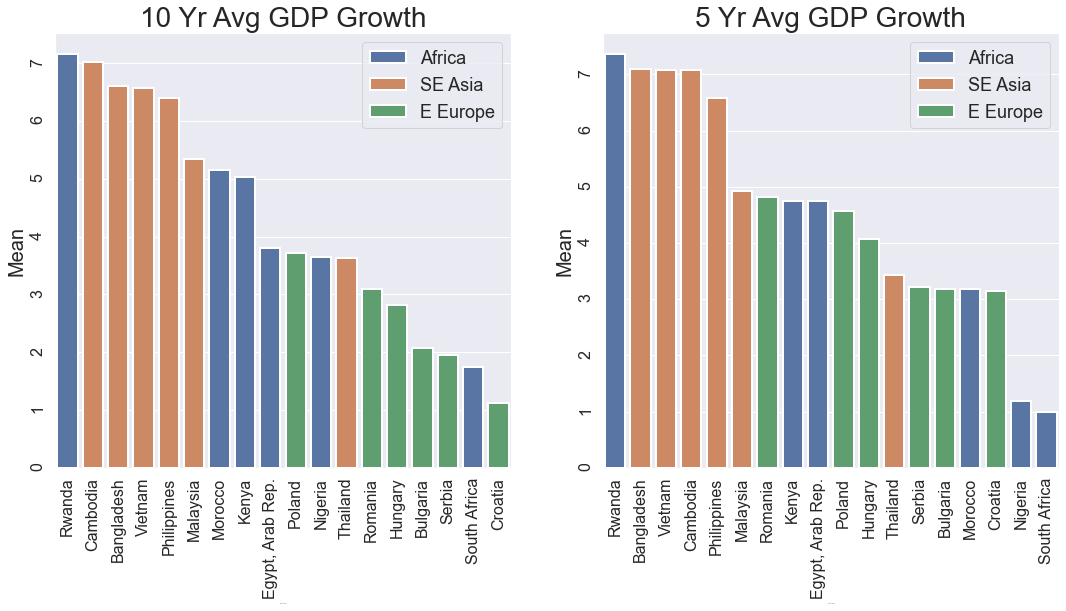

In [192]:
# Generate bar charts comparing 10 and 5 year averages for a given indicator

# Set dates for 10-year chart
start_date_10 = '2010-01-01'
end_date_10 = '2019-01-01'

# Set dates for 5-year chart
start_date_5 = '2015-01-01'
end_date_5 = '2019-01-01'

# Set indicator codes for each chart
indic_code_10 = 'NY.GDP.MKTP.KD.ZG'
indic_code_5 = 'NY.GDP.MKTP.KD.ZG'



# 10 Year Chart ----------------------------------------------------------------------------------------

# Get raw data from df_select_countries
gdp_growth_10 = np.round(single_indicator_analyzer(df_select_countries_regions,
                                                   indic_code_10,
                                                   start_date_10,
                                                   end_date_10),2)
# Calculate mean
gdp_growth_10_mean = gdp_growth_10.mean()

# Sort mean data in descending order
gdp_growth_10_mean_sorted = gdp_growth_10_mean.sort_values(ascending=False)

# Put this newly created series into df
gdp_growth_df_10 = pd.DataFrame(gdp_growth_10_mean_sorted)

# Add name and create Mean column
gdp_growth_df_10.columns = ['Mean']

# Create column with Country Name
gdp_growth_df_10['Country Name'] = gdp_growth_df_10.index

# Create column for Region and map to Country Names
gdp_growth_df_10['Region'] = gdp_growth_df_10['Country Name'].map(regions)

# Review newly created 10-year df
#print(gdp_growth_df_10)


# 5 Year chart ----------------------------------------------------------------------------------------

# Get raw data from df_select_countries
gdp_growth_5 = np.round(single_indicator_analyzer(df_select_countries_regions,
                                                   indic_code_5,
                                                   start_date_5,
                                                   end_date_5),2)
# Calculate mean
gdp_growth_5_mean = gdp_growth_5.mean()

# Sort mean data in descending order
gdp_growth_5_mean_sorted = gdp_growth_5_mean.sort_values(ascending=False)

# Put this newly created series into df
gdp_growth_df_5 = pd.DataFrame(gdp_growth_5_mean_sorted)

# Add name and create Mean column
gdp_growth_df_5.columns = ['Mean']

# Create column with Country Name
gdp_growth_df_5['Country Name'] = gdp_growth_df_5.index

# Create column for Region and map to Country Names
gdp_growth_df_5['Region'] = gdp_growth_df_5['Country Name'].map(regions)

# Review newly created 5-year df
#gdp_growth_df_5

# Create actual charts ---------------------------------------------------------------------------------------------

# Create subplots
fig, ax = plt.subplots(1, 2)

# Set size of figure    
fig.set_size_inches(18, 8)

# Make 10-year chart
plt.subplot(1,2,1)

chart_10 = sns.barplot(data=gdp_growth_df_10,
                    x='Country Name',
                    y='Mean',
                    hue='Region',
                    linewidth = 2,
                    dodge=False)

# Format 10-year chart
plt.title("10 Yr Avg GDP Growth",fontsize=28)
plt.xlabel('Country Name',fontsize=0)
plt.ylabel('Mean',fontsize=20)
plt.tick_params(labelsize=16,rotation=90)
plt.legend(fontsize=18)


# Make 5-year chart
plt.subplot(1,2,2)

chart_2 = sns.barplot(data=gdp_growth_df_5,
                    x='Country Name',
                    y='Mean',
                    hue='Region',
                    linewidth = 2,
                    dodge=False)

# Format 5-year chart
plt.title("5 Yr Avg GDP Growth",fontsize=28)
plt.xlabel('Country Name',fontsize=0)
plt.ylabel('Mean',fontsize=20)
plt.tick_params(labelsize=16,rotation=90)
plt.legend(fontsize=18)

# Show charts
plt.show()

These charts make a strong case for Rwanda, Bangladesh, Cambodia, Vietnam and The Philippines.

# We might also want to see how the charts above compare to global averages over time. After all, what is considered "high" GDP Growth?

In [193]:
# Calculate average GDP growth for both 'high'and 'low' growth groups of countries
gdp_growth_high_v_low = group_by_high_low(df_economy_people,'NY.GDP.MKTP.KD.ZG','mean','2010-01-01','2019-01-01',3.25)
gdp_growth_high_v_low

Mean of mean_by_country Value    3.287469
dtype: float64
Median of mean_by_country Value    3.134938
dtype: float64


,mean
Value,
high_growth,5.09
low_growth,1.55


This shows that mean GDP Growth for all countries since 2010 has been ~3.25%.  An average "high-growth" country has experienced growth of ~5.1% on average, so the top 5 countries on the bar charts above are performing above average - even for the high-growth group.

# We might also want the ability to compare any one of these indicators for any regional group of countries.  This will allow us to compare statistics and identify trends over time.

In [194]:
def country_indicator_comparison(indf,region,indicator_code,start_date,end_date,interpolation):
    
    
    """Creates multiple line charts comparing countries in a region for a given indicator variable
    
    indf -- df_select_countries
    region -- one of 'Africa', 'E Europe', 'SE Asia'
    indicator_code -- unique code for chosen indicator
    start_date -- beginning of range
    end_date -- end of range
    interpolation --- one of 'linear' or 'basis'
    
    """
    # Data preprocessing steps
    
    # Get copy of input df
    comparison_df = indf.copy()
    
    # Make year the index
    comparison_df.set_index('Year',inplace=True)
    
    # Convert Year into pd.DateTime format
    comparison_df.index = pd.to_datetime(comparison_df.index)
   
    # Create copy of index col as regular df col
    comparison_df['Year'] = comparison_df.index
    #print(comparison_df.head())
    
    # Take subset of comparison_df based on chosen Region
    df_region = comparison_df[comparison_df['Region']==region]
    #print(df_region.head())
    
    # Take subset of df_region based on a given Indicator
    df_indic = df_region[df_region['Indicator Code']==indicator_code]
    
    # Take subset of df_indic based on a given date range
    df_date_range = df_indic.loc[(df_indic.index >= start_date)
                     & (df_indic.index <= end_date)]
    
    # Round Values to two digits
    df_date_range_rounded = df_date_range.copy() 
    df_date_range_rounded['Value'] = np.round(df_date_range_rounded['Value'],2)

    
    # Create chart

    # Create base lines
    line = alt.Chart(df_date_range_rounded).mark_line(interpolate=interpolation).encode(
        x=alt.X('Year:T'),
        y='Value:Q',
        color='Country Name:N',
        tooltip='Country Name:N'
    )

    # Create selection object based on nearest point
    nearest = alt.selection(type='single', nearest=True, on='mouseover',
                            fields=['Year'], empty='none')
    
    #  Add clear selector based on Year & link to nearest selection object
    selectors = alt.Chart(df_date_range_rounded).mark_point().encode(
        x='Year:T',
        opacity=alt.value(0),
    ).add_selection(
        nearest
    )

    # Add dots to line & use condition function to link to nearest
    points = line.mark_point().encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))
    )

    # Create text labels & use condition function link to nearest
    text = line.mark_text(align='left', dx=5, dy=-5).encode(
        text=alt.condition(nearest, 'Value:Q', alt.value(' '))
    )

    # Add vertical line based on condition in nearest
    rules = alt.Chart(df_date_range_rounded).mark_rule(color='gray').encode(
        x='Year:T',
    ).transform_filter(
        nearest
    )

    # Combine all of the elements
    combined = alt.layer(
        line, selectors, points, rules, text
    ).properties(
        width=800, height=400
    )
    
    return combined


In [195]:
# Create line charts for each country in a chosen region comparing a single indicator over time
multi_line_comp = country_indicator_comparison(df_select_countries_regions,
                                               'SE Asia','NY.GDP.MKTP.KD.ZG',
                                               '2010-01-01','2019-01-01','linear')
multi_line_comp

alt.LayerChart(...)

# It is also helpful to analyze our groups of countries using pairs of indicators.  This could help us spot outliers, and see general relationships between different indicators.

For example, how does GDP Growth compare to Population?  The size of the population governs the size of the potential labor pool.

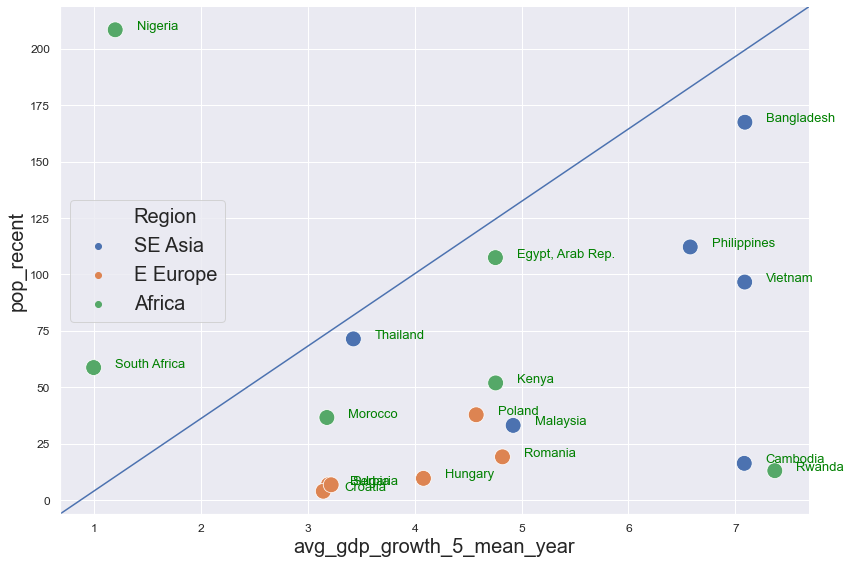

In [196]:
# Create scatter plot comparing population vs. population growth
pop_pop_gr_scatter = scatter_plot_chart(df_combined_series,'avg_gdp_growth_5_mean_year','pop_recent')

Interesting!  Rwanda and Cambodia both have high GDP but their populations are relatively small.

Another important factor is worker productivity.  So let's compare GDP Growth to GDP Per Capita as a proxy for productivity.

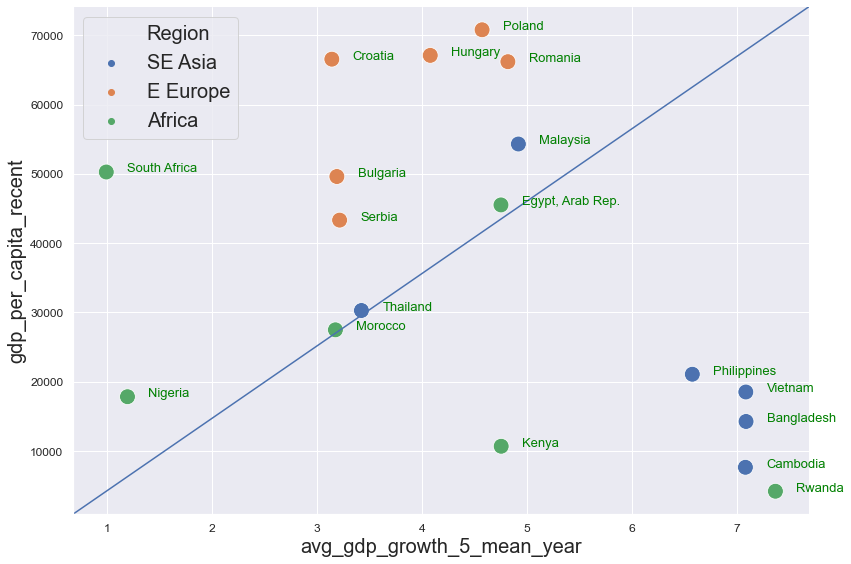

In [197]:
# Create scatter plot comparing GDP Growth vs. GDP Per Capita
gdp_gr_v_gdp_per_cap = scatter_plot_chart(df_combined_series,'avg_gdp_growth_5_mean_year','gdp_per_capita_recent')

It looks like Rwanda and Cambodia have the lowest GDP Per Capita in the group.

We can also analyze what % of each country's workforce is employed in Industrial activities.

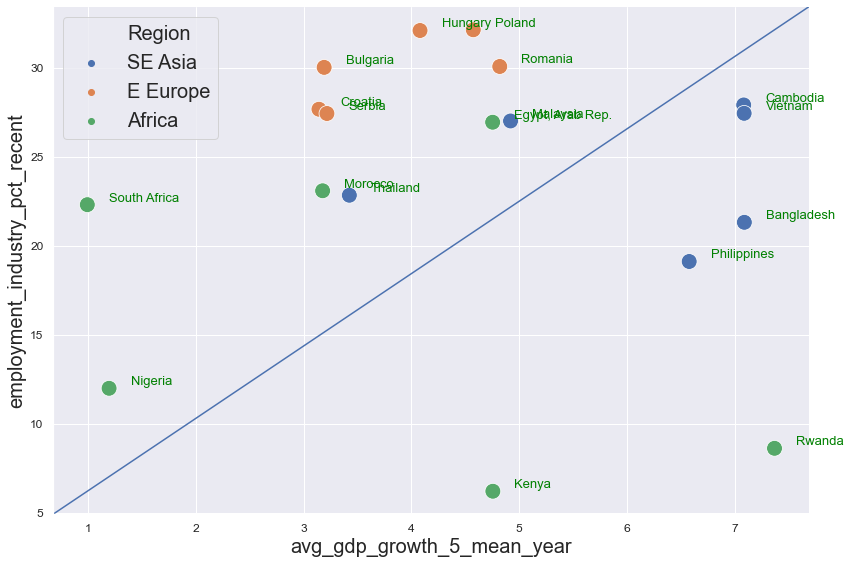

In [198]:
# Create scatterplot of GDP Growth vs % of Workers Employed In Industry
gdp_gr_v_ind_employment = scatter_plot_chart(df_combined_series,'avg_gdp_growth_5_mean_year','employment_industry_pct_recent')

A smaller part of Rwanda's economy is focused on manufacturing (compared to services or agriculture) compared to its peer group.  The Philippines is also on the lower end of the range.

Among those countries where manufacturing is a significant % of the economy, how involved has the government been in investing in education?  This is a proxy for the education level of the workforce.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


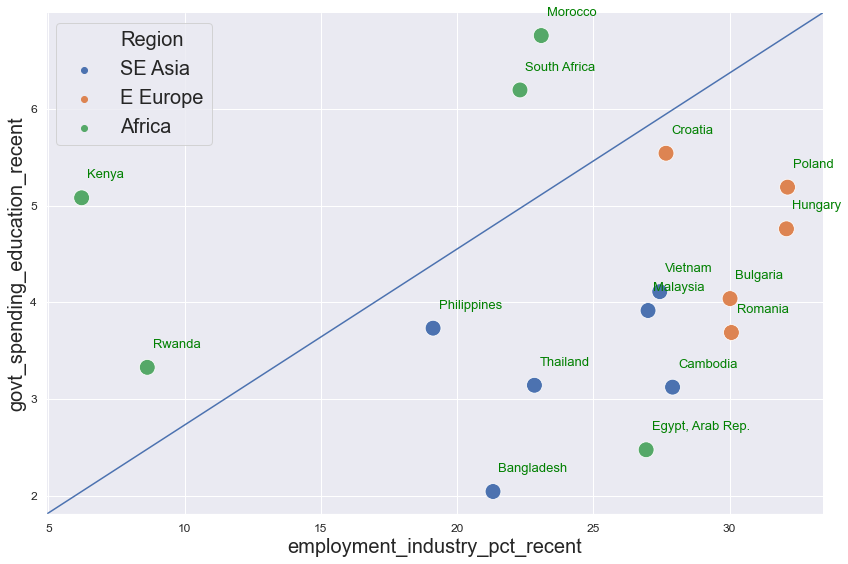

In [199]:
# Create scatterplot of % of Workers In Indstry vs Government Spending On Education
education_manuf_scatter = scatter_plot_chart(df_combined_series,'employment_industry_pct_recent',
                                             'govt_spending_education_recent')


Note that data was not available for all countrues, but for those where data was available there are relatively clear regional groupings.

# Although these scatter plot charts provide a directional indication as to the relationship between indicators, correlation analysis would allow for more precise estimates.

In [200]:
# Calculate correlation coefficients between chosen indicators in most recent year available
df_combined_series_corr = (df_combined_series.corr()).round(2)
df_combined_series_corr

,gdp_recent,gdp_growth_recent,gdp_per_capita_recent,female_male_ratio_recent,employment_industry_pct_recent,unemployment_recent,pop_recent,pop_gr_recent,govt_spending_education_recent,life_expectancy_male_recent,life_expectancy_female_recent,adolescent_fertility_recent,avg_gdp_growth_5_mean_year,avg_gdp_growth_10_mean_year
gdp_recent,1.00,0.16,0.17,-0.27,0.11,0.05,0.60,0.10,-0.17,0.01,0.04,0.20,-0.11,0.03
gdp_growth_recent,0.16,1.00,-0.27,-0.14,-0.05,-0.13,0.39,0.19,-0.50,-0.22,-0.18,0.26,0.33,0.25
gdp_per_capita_recent,0.17,-0.27,1.00,-0.19,0.72,0.22,-0.43,-0.73,0.34,0.47,0.51,-0.59,-0.45,-0.75
female_male_ratio_recent,-0.27,-0.14,-0.19,1.00,-0.30,-0.21,-0.29,-0.01,0.10,-0.29,-0.17,-0.04,0.06,0.02
employment_industry_pct_recent,0.11,-0.05,0.72,-0.30,1.00,-0.06,-0.39,-0.79,0.03,0.71,0.74,-0.63,-0.06,-0.39
unemployment_recent,0.05,-0.13,0.22,-0.21,-0.06,1.00,0.10,0.09,0.54,-0.36,-0.34,0.26,-0.68,-0.49
pop_recent,0.60,0.39,-0.43,-0.29,-0.39,0.10,1.00,0.57,-0.46,-0.49,-0.54,0.75,-0.01,0.29
pop_gr_recent,0.10,0.19,-0.73,-0.01,-0.79,0.09,0.57,1.00,-0.20,-0.67,-0.74,0.66,0.22,0.63
govt_spending_education_recent,-0.17,-0.50,0.34,0.10,0.03,0.54,-0.46,-0.20,1.00,-0.09,-0.03,-0.33,-0.66,-0.45
life_expectancy_male_recent,0.01,-0.22,0.47,-0.29,0.71,-0.36,-0.49,-0.67,-0.09,1.00,0.97,-0.78,0.26,-0.08


This is interesting data but difficult to read.  It will likely be easier to interpret in a heatmap.

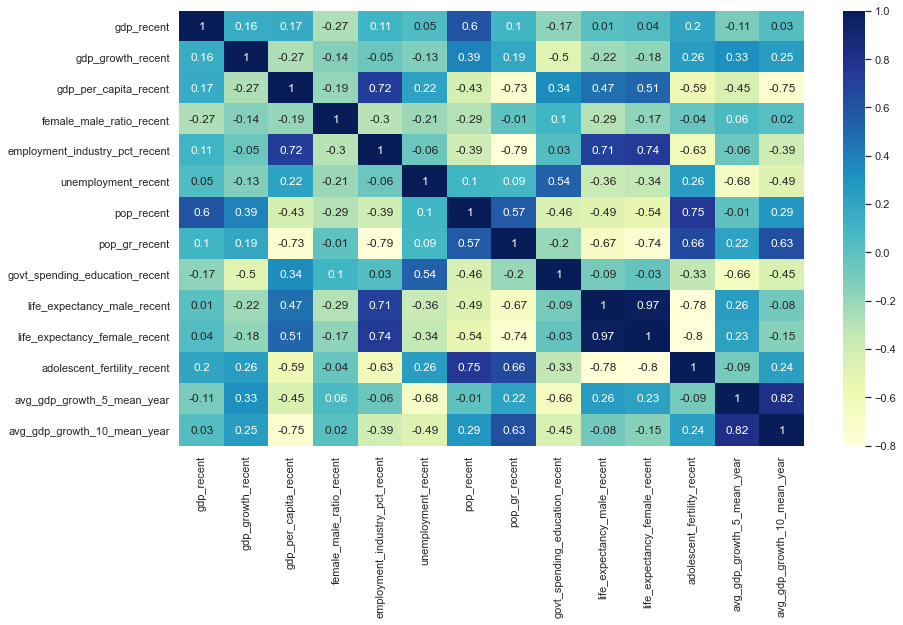

In [201]:
# Create heatmap of correlation data

# Create figure
fig = plt.gcf()
fig.set_size_inches(14, 8)
sns.set()

# Create correlation heatmap
ax = sns.heatmap(df_combined_series_corr, annot=True,cmap="YlGnBu")

# Show the heatmap
plt.show()

The heatmap highlights some very interesting relationships:
1.  One year of GDP Growth data doesn't have a particularly strong relationship with the other variables. However, longer-term (5 or 10 year averages) tend to have stronger relationships.
2.  Life Expectancy (both male and female) both positively correlted to level of Industrial Activity.
3.  Unemployment negatively correlated to Life Expectancy.
4.  GDP Per Capita has a strong positive correlation with the level of Industrial Activity and a negative correlation with both the rate of Population Growth and Adolescent Fertility levels.
5.  The rate of Population Growth is strongly negatively correlated to Industrial Activity.
6.  Adolescent Fertility levels are strongly negatively correlated to Life Expectancy.
7.  Government Spending On Education has a strong positive correlation to Unemployment. This seems counterintuitive.

# Stopping at this point in the analysis would lead to a recommendation based solely on economic indicators.  Perhaps Bangladesh might be the choice.

# However, the Data Science Team has a formal Ethical Commitment in its internal policies:  "We will always provide a balanced perspective in our analysis".

# In this context, this means an obligation to look beyond solely Economic factors and focus on the human impact of our analysis.  Not only is this approach good PR for the Company, it is also more ethical.

One area worth noting is the discrepancy in female participation in the respective workforces.

Comparing GDP Growth to the ratio of Females to Males In the Workforce paints a more nuanced picture.

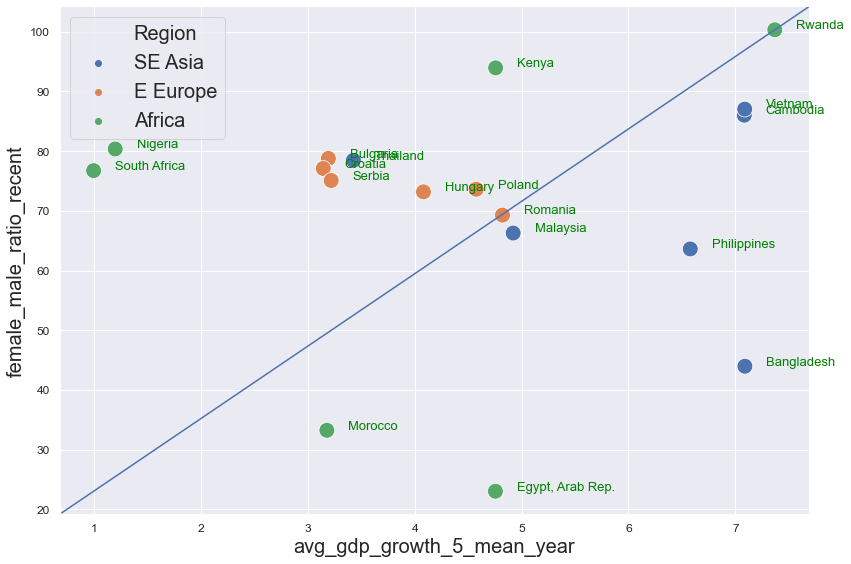

In [202]:
# Create scatterplot of GDP Growth vs. the Female-Male Workforce ratio.
gdp_gr_v_female_male_ratio_scatter = scatter_plot_chart(df_combined_series,'avg_gdp_growth_5_mean_year','female_male_ratio_recent')
gdp_gr_v_female_male_ratio_scatter

This chart shows Bangladesh, Morocco and Egpyt as outliers.  Perhaps these stats reflect cultural factors, but it could also mean some countries are not providing women with equal opportunities.

In [203]:
#female_male_life_exp_scatter = scatter_plot_chart(df_combined_series,
#                                                  'gdp_growth_recent','life_expectancy_male_recent')

The relationship between the Adolescent Fertility rate and GDP Growth is also noteworthy. Nigeria and Bangladesh stand out.

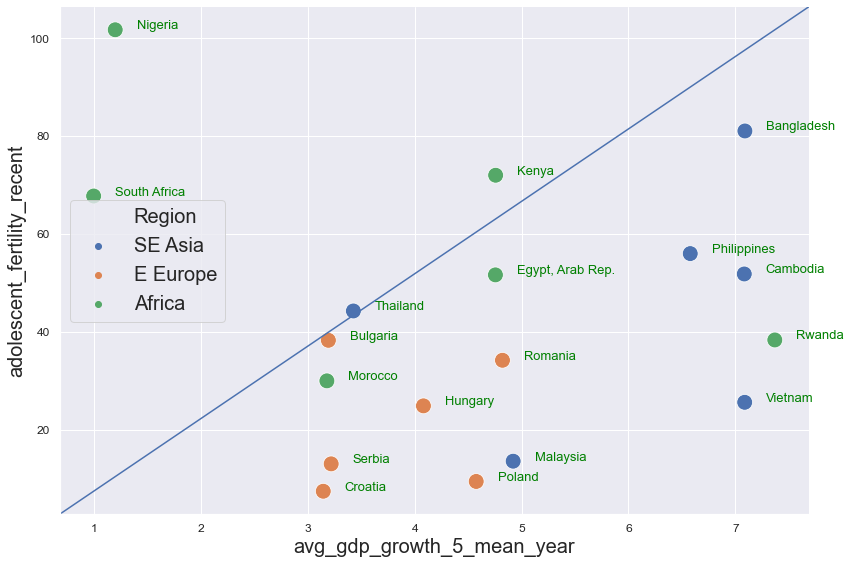

In [204]:
# Create scatterplot of Female-Male Workforce Ratio vs. Adolescent Fertility
female_male_adolescent_fertility_scatter = scatter_plot_chart(df_combined_series,
                                                  'avg_gdp_growth_5_mean_year',
                                                  'adolescent_fertility_recent')

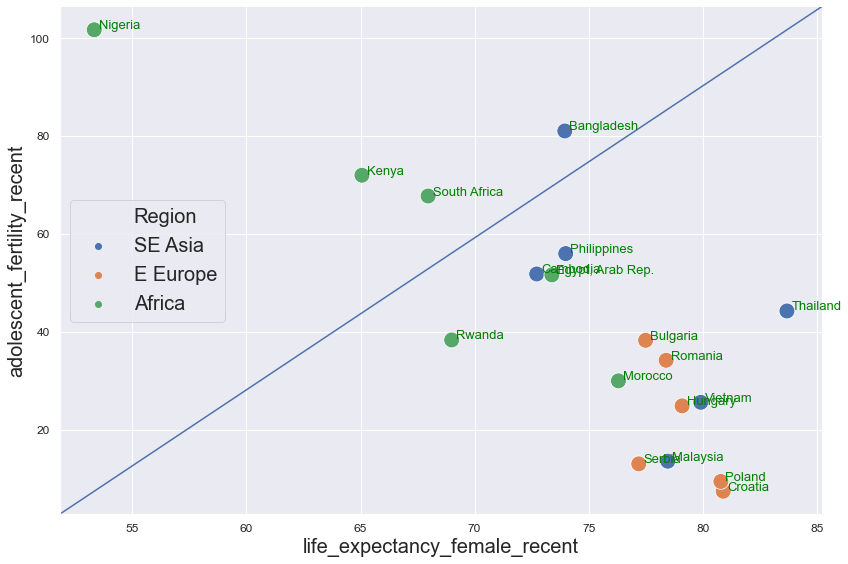

In [205]:
# Create scatterplot of Youth Fertility vs. Female Life Expectancy
female_life_expect_adolescent_fertility_scatter = scatter_plot_chart(df_combined_series,
                                                  'life_expectancy_female_recent',
                                                  'adolescent_fertility_recent')

The chart shows a fairly pronounced negative correlation.  A higher Adolescent Fertility rate ultimately lead to a lower Life Expectancy.

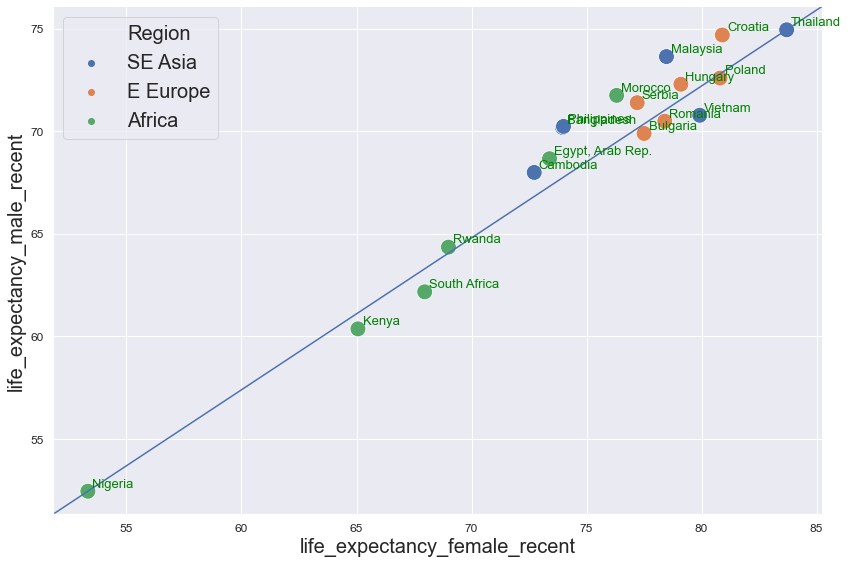

In [206]:
# Create scatterplot of Male vs Female Life Expectancy
female_v_male_life_expect_scatter = scatter_plot_chart(df_combined_series,
                                                  'life_expectancy_female_recent',
                                                  'life_expectancy_male_recent')

# Recommendation:

Based on the preliminary review of GDP Growth numbers, Rwanda, Cambodia, Bangladesh, The Philippines or Vietnman looked like reasonable choices.

As we dug further into various Economic indicators, Rwanda and Cambodia both have relatively small populations, and Rwanda also has a very small industrial sector.

Bangladesh seemed to be a solid option -- high GDP Growth, large workforce, significant industrial segment.

However, a more complete look which includes both Economy and People-based indicators provides a more balanced perspective.  Bangladesh has relatively low workforce participation by women and a very high adolescent fertility rate.  Both of these factors warrant reconsidering the location of the manufacturing facility.

Based on these considerations, the recommendation is......Vietnam.

# Strategic Rationale:

1.  High-growth economy
2.  Large population
3.  Significant industrial component to its economy
4.  Solid productivity
5.  Relatively high participation by women
6.  Relatively low Adolescent Fertility rate

    

# Dependencies

In [207]:
from platform import python_version
print("Python: ",python_version())
print("Pandas:",pd.__version__)
print("Numpy:",np.__version__)
print("Altair:",alt.__version__)
print("Seaborn:",sns.__version__)
print("Plotly:",plotly.__version__)
print("Matplotlib: ",mpl.__version__)

Python:  3.8.3
Pandas: 1.0.5
Numpy: 1.23.5
Altair: 4.2.0
Seaborn: 0.10.1
Plotly: 5.9.0
Matplotlib:  3.2.2
